In [1]:
import numpy as np
import os
import cv2
from skimage.feature import graycomatrix, graycoprops
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

In [2]:
# Set the path to your input and output image dataset directories
dir_path = 'brain_tumor/data/'

In [3]:
# Contrast: measures the local variations in the gray-level co-occurrence matrix. Higher contrast values indicate a greater difference between the co-occurring gray-level values and therefore greater textural heterogeneity.

# Dissimilarity: measures the average difference in the gray-level values between adjacent pixels. Higher dissimilarity values indicate greater textural heterogeneity.

# Homogeneity: measures the closeness of the distribution of elements in the GLCM to the GLCM diagonal. Higher homogeneity values indicate a more homogeneous texture.

# Energy: measures the sum of squared elements in the GLCM. Higher energy values indicate a more homogeneous texture.

# Correlation: measures the degree of linear dependency between the gray-level values in the image. Higher correlation values indicate a more linear relationship between the gray-level values.

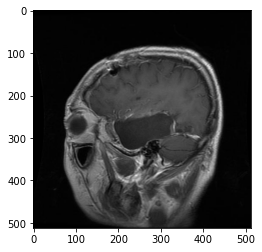

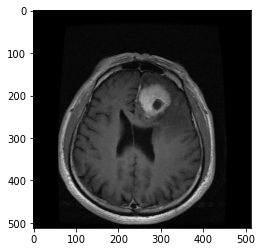

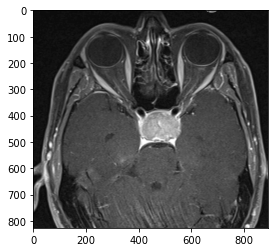

In [4]:
# initialize feature matrix and label vector
g, m, p = 0, 0, 0
features = np.zeros((0, 60))
tumor_v = np.zeros(0)
distances=[1, 3, 5]
properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]
# loop over the four tumor categories and extract features from each image
for category in ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']:
    category_path = os.path.join(dir_path, category) + '/'
    for i, file_name in enumerate(os.listdir(category_path)):
        # read in image and convert to grayscale
        img = cv2.imread(os.path.join(category_path, file_name), cv2.IMREAD_GRAYSCALE)
        glcm = graycomatrix(img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
        glcm_features = []
        for prop in properties:
            glcm_features.append(graycoprops(glcm, prop).ravel())
        glcm_features = np.concatenate(glcm_features)

        # add features to feature matrix and label the image accordingly
        features = np.vstack((features, glcm_features))
        if category == 'glioma_tumor':
            if g == 0:
                plt.imshow(img, cmap='gray')
                plt.show()
                g = 1
            tumor_v = np.append(tumor_v, 0)
        elif category == 'meningioma_tumor':
            tumor_v = np.append(tumor_v, 1)
            if m == 0:
                plt.imshow(img, cmap='gray')
                plt.show()
                m = 1
        elif category == 'no_tumor':
            tumor_v = np.append(tumor_v, 3)            
        elif category == 'pituitary_tumor':
            if p == 0:
                plt.imshow(img, cmap='gray')
                plt.show()
                p = 1
            tumor_v = np.append(tumor_v, 2)

In [5]:
columns = []
for distance in distances:
    for angle in angles:
        for prop in properties:
            column_name = f'{prop}_d{distance}_a{int(angle*180/np.pi)}'
            columns.append(column_name)

# create pandas DataFrame from feature matrix and label vector
data = np.hstack((features, tumor_v.reshape(-1, 1)))
df = pd.DataFrame(data=data, columns= columns + ['tumor_type'])
df['tumor_type'] = df['tumor_type'].astype(int)

In [12]:
df

,contrast_d1_a0,dissimilarity_d1_a0,homogeneity_d1_a0,energy_d1_a0,correlation_d1_a0,contrast_d1_a45,dissimilarity_d1_a45,homogeneity_d1_a45,energy_d1_a45,correlation_d1_a45,...,dissimilarity_d5_a90,homogeneity_d5_a90,energy_d5_a90,correlation_d5_a90,contrast_d5_a135,dissimilarity_d5_a135,homogeneity_d5_a135,energy_d5_a135,correlation_d5_a135,tumor_type
359,42.976131,87.703475,49.468165,88.858583,292.370936,271.800980,289.275747,279.697305,563.618844,611.222685,...,0.974059,0.914575,0.920592,0.915591,0.918285,0.835137,0.821199,0.851332,0.808052,0
1498,139.492556,233.882291,100.798548,234.873909,1024.391381,810.248879,718.323238,812.381677,2165.826882,2248.994369,...,0.967174,0.856586,0.886060,0.899254,0.885760,0.695680,0.680384,0.789451,0.679670,1
1469,38.508470,79.045852,43.084584,74.952332,253.566445,238.886920,243.562853,226.153849,478.852310,549.659449,...,0.980134,0.932851,0.936793,0.935500,0.940162,0.873414,0.855073,0.885746,0.860835,1
70,44.870046,90.330196,45.456584,81.742506,306.936034,282.139293,282.073206,258.162845,587.797149,627.597325,...,0.965288,0.869583,0.880157,0.880290,0.890342,0.750093,0.733330,0.783395,0.744935,0
385,29.787029,73.349493,43.067977,67.670348,221.903963,244.910915,275.280494,224.008131,485.094779,653.984763,...,0.981594,0.939651,0.933431,0.925183,0.939112,0.868141,0.822511,0.852357,0.837425,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2753,49.003471,81.465190,39.061881,84.720402,288.394738,239.425190,225.033437,250.200892,486.036928,504.901342,...,0.977959,0.924959,0.937696,0.941459,0.934892,0.873494,0.868571,0.897213,0.860474,2
3027,51.322663,103.569276,45.387812,84.196074,336.132793,340.429977,305.768422,272.186225,698.342775,879.100471,...,0.968392,0.873604,0.871878,0.885123,0.897562,0.736735,0.667279,0.773903,0.731914,2
1484,54.193409,114.404709,58.254105,98.970807,368.019232,348.610765,319.399796,298.964683,714.277051,781.098712,...,0.974821,0.906447,0.911451,0.918806,0.924061,0.818714,0.802219,0.857683,0.829291,1
1501,25.575480,43.428334,16.992096,39.074544,196.091302,148.639862,106.460136,133.156947,454.600453,448.300681,...,0.992598,0.962882,0.971897,0.979862,0.974824,0.914088,0.915577,0.958611,0.923805,1


In [13]:
df.to_csv('brain_tumor_image.csv')

In [8]:
df.tumor_type.value_counts()

1    937
0    926
2    901
3    501
Name: tumor_type, dtype: int64

In [9]:
df = df[df.tumor_type != 3].copy()

In [10]:
df.tumor_type.value_counts()

1    937
0    926
2    901
Name: tumor_type, dtype: int64

In [11]:
df = df.sample(frac=1)
df.head()

,contrast_d1_a0,dissimilarity_d1_a0,homogeneity_d1_a0,energy_d1_a0,correlation_d1_a0,contrast_d1_a45,dissimilarity_d1_a45,homogeneity_d1_a45,energy_d1_a45,correlation_d1_a45,...,dissimilarity_d5_a90,homogeneity_d5_a90,energy_d5_a90,correlation_d5_a90,contrast_d5_a135,dissimilarity_d5_a135,homogeneity_d5_a135,energy_d5_a135,correlation_d5_a135,tumor_type
359,42.976131,87.703475,49.468165,88.858583,292.370936,271.800980,289.275747,279.697305,563.618844,611.222685,...,0.974059,0.914575,0.920592,0.915591,0.918285,0.835137,0.821199,0.851332,0.808052,0
1498,139.492556,233.882291,100.798548,234.873909,1024.391381,810.248879,718.323238,812.381677,2165.826882,2248.994369,...,0.967174,0.856586,0.886060,0.899254,0.885760,0.695680,0.680384,0.789451,0.679670,1
1469,38.508470,79.045852,43.084584,74.952332,253.566445,238.886920,243.562853,226.153849,478.852310,549.659449,...,0.980134,0.932851,0.936793,0.935500,0.940162,0.873414,0.855073,0.885746,0.860835,1
70,44.870046,90.330196,45.456584,81.742506,306.936034,282.139293,282.073206,258.162845,587.797149,627.597325,...,0.965288,0.869583,0.880157,0.880290,0.890342,0.750093,0.733330,0.783395,0.744935,0
385,29.787029,73.349493,43.067977,67.670348,221.903963,244.910915,275.280494,224.008131,485.094779,653.984763,...,0.981594,0.939651,0.933431,0.925183,0.939112,0.868141,0.822511,0.852357,0.837425,0


In [21]:
def get_cv_error(model, X, y):
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
        print(f'The Cross Validated Mean Error Score for {model} : {scores.mean()}')  

In [22]:
scaler = StandardScaler()

In [23]:
# separate the features and the target variable
X = df.drop('tumor_type', axis=1)
y = df['tumor_type']
X_scaled = scaler.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# evaluate the model
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.8240963855421687


### PCA

In [115]:
from sklearn.decomposition import PCA

In [116]:
X = df.drop('tumor_type', axis=1)
y = df['tumor_type']
X_features = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_features)

In [118]:
X_pca

array([[ 3.21518853e-01, -2.66981147e+00,  9.34106102e-02, ...,
         1.07491672e-03, -2.54747339e-03,  6.10555399e-04],
       [ 2.38945241e+00, -2.87090902e+00, -3.57307280e-02, ...,
         6.19219011e-04, -3.66708165e-04,  2.23492959e-05],
       [ 8.97634408e-02, -4.02302003e+00, -1.13738628e+00, ...,
        -3.50046382e-04, -3.05443011e-04, -1.86704552e-04],
       ...,
       [-6.35669115e+00,  3.75798265e+00,  5.79825407e-01, ...,
         3.55051686e-04,  8.17553005e-05,  6.76549066e-05],
       [-3.50568294e+00, -3.61709022e-01,  5.44170290e-01, ...,
         3.99359525e-04, -1.13524277e-03, -7.84032823e-06],
       [ 1.97590099e+00, -3.93261584e+00, -3.61094654e-01, ...,
         4.57384910e-04, -5.41174372e-04,  3.26711721e-04]])

In [119]:
variance_df = pd.DataFrame({'explained_variance_ratio': pca.explained_variance_ratio_, 'explained_variance':pca.explained_variance_})
variance_df.index += 1
variance_df.index.name = 'Principal Component'

variance_df['cumulative_variance'] = variance_df['explained_variance_ratio'].cumsum()

variance_df.reset_index(inplace=True)

In [120]:
variance_df.head()

,Principal Component,explained_variance_ratio,explained_variance,cumulative_variance
0,1,0.642838,38.584221,0.642838
1,2,0.253385,15.208595,0.896223
2,3,0.060855,3.652599,0.957077
3,4,0.015891,0.953820,0.972968
4,5,0.012066,0.724238,0.985035


In [121]:
### Based on the scree plot and the cumulative variance plot, taking 5 components seem to cover 98% of the variance of the features

In [122]:
## See if we can plot images after pca?

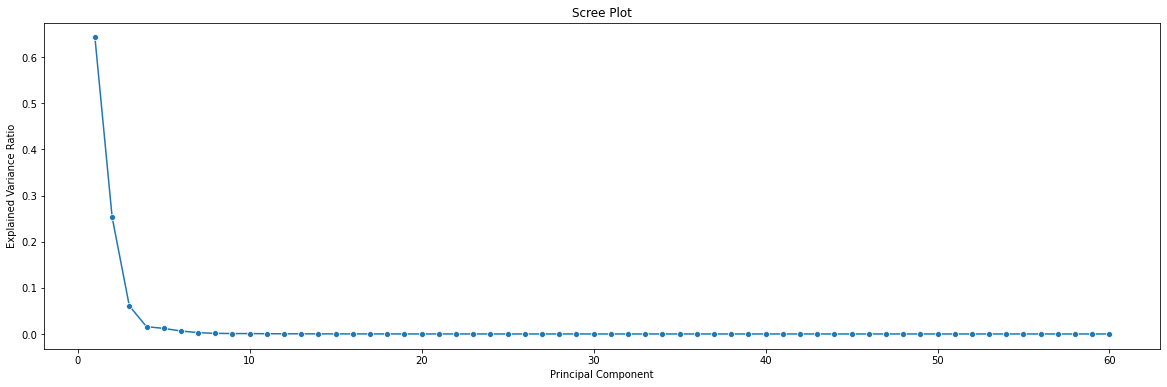

In [123]:
plt.figure(figsize=(20,6))
sns.lineplot(x='Principal Component', y= 'explained_variance_ratio', data=variance_df, marker = 'o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

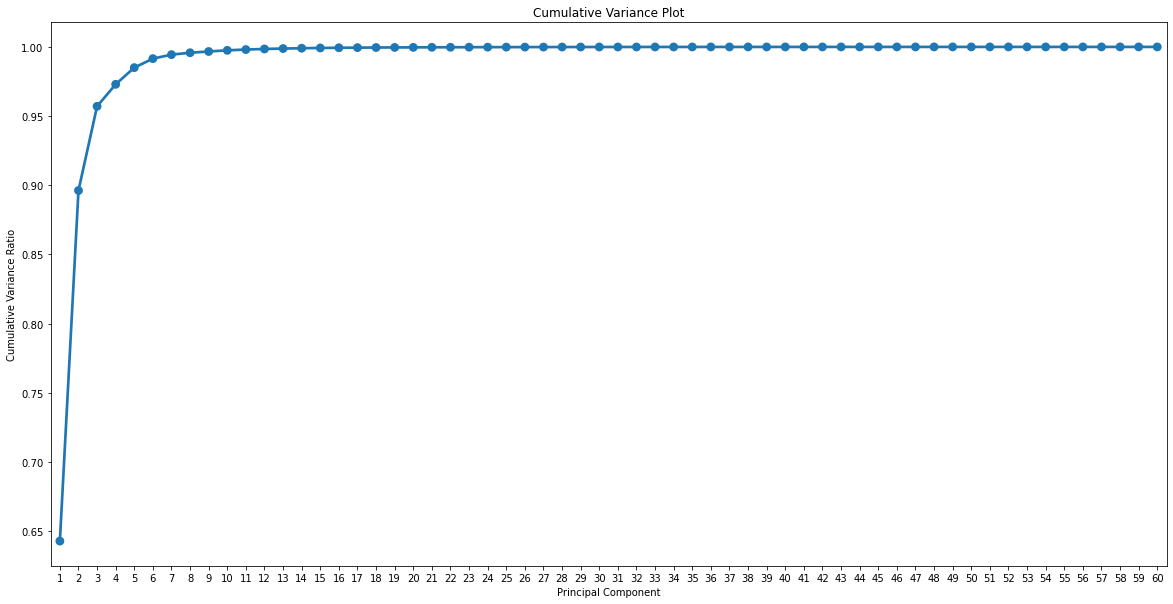

In [124]:
plt.figure(figsize=(20,10))
sns.pointplot(x='Principal Component', y= 'cumulative_variance', data=variance_df)
plt.title('Cumulative Variance Plot')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance Ratio')
plt.show()

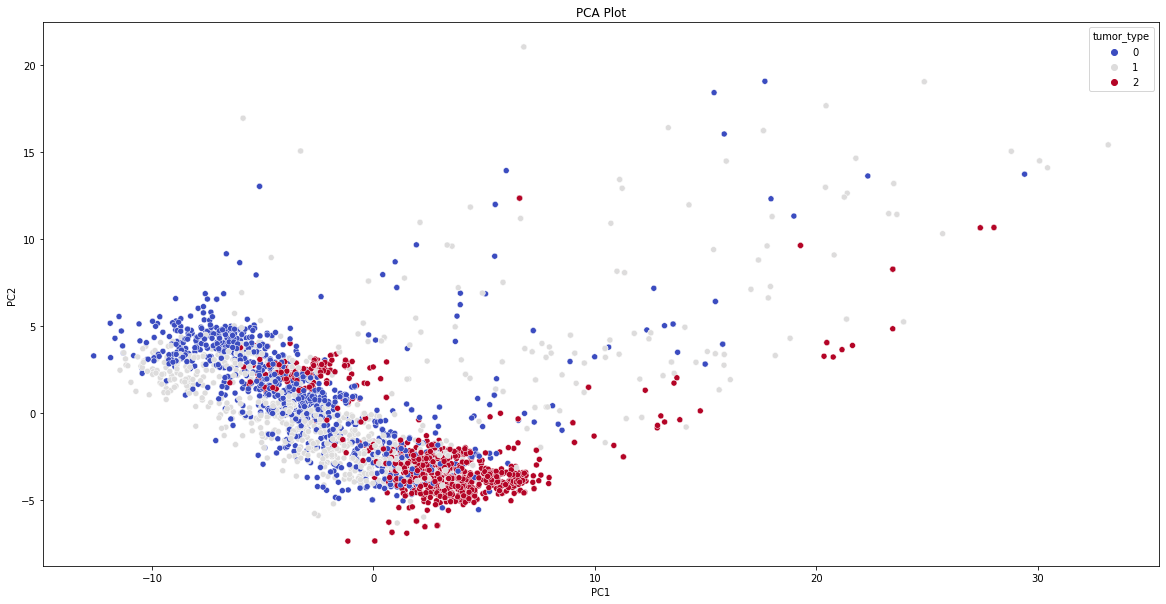

In [125]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Plot')
plt.show()

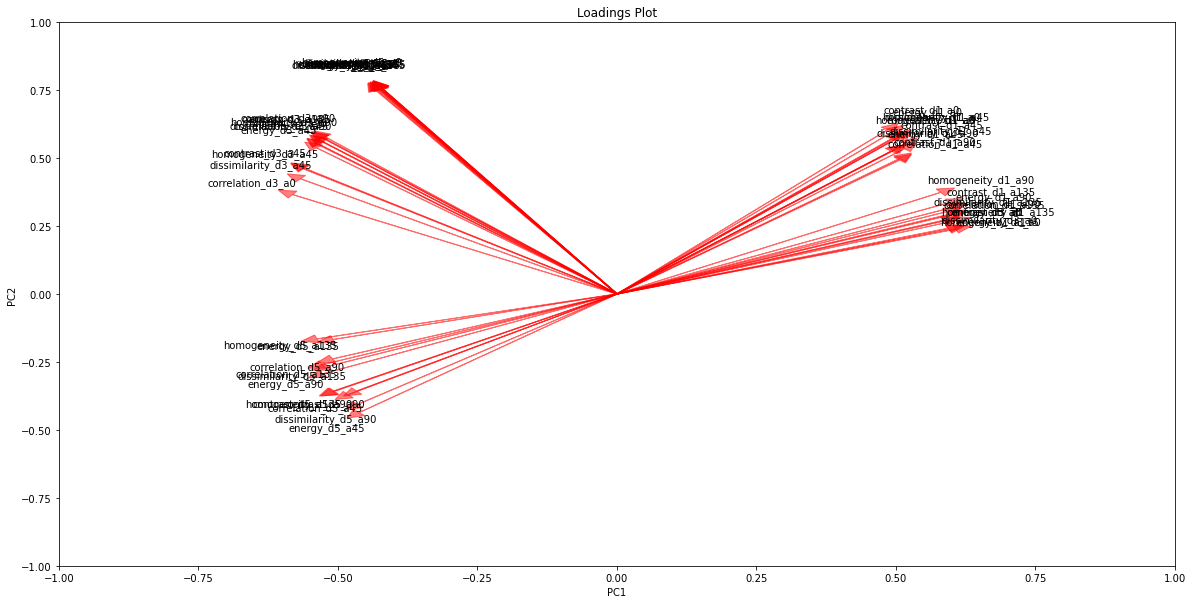

In [126]:
loadings = pca.components_[:2, :]
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Loadings Plot')

for i, feature in enumerate(df.columns[:-1]):
    ax.arrow(0, 0, loadings[0, i]*4, loadings[1, i]*4, color='r', alpha=0.5, head_width=0.03, head_length=0.03)
    ax.text(loadings[0, i]*4.5, loadings[1, i]*4.5, feature, color='k', ha='center', va='center')

plt.show()


In [127]:
pca = PCA(n_components = 6)
X_pca = pca.fit_transform(X_features)

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, df['tumor_type'], test_size=0.3, random_state=42)

In [129]:
# train an LDA classification model
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

# evaluate the model
y_pred = lda.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: QDA", acc)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = knn.score(X_test, y_test)
print("Accuracy: KNN ", accuracy)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# evaluate the model
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy Random Forests:", acc)

Accuracy: QDA 0.5939759036144578
Accuracy: KNN  0.7385542168674699
Accuracy Random Forests: 0.8180722891566266


In [130]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80       292
           1       0.78      0.79      0.79       286
           2       0.83      0.91      0.87       252

    accuracy                           0.82       830
   macro avg       0.82      0.82      0.82       830
weighted avg       0.82      0.82      0.82       830



In [63]:
get_cv_error(rf,X_pca, df['tumor_type'])

The Cross Validated Mean Error Score for RandomForestClassifier(random_state=42) : 0.8143990617711037


In [64]:
## Grid Search CV of RF

In [65]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 14],
    'min_samples_leaf': [1, 2, 4, 6]
}
rfc = RandomForestClassifier(random_state=40)

grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding mean test score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean test score: ", grid_search.best_score_)

Best hyperparameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best mean test score:  0.7973223012143364


In [66]:
rf = RandomForestClassifier(n_estimators=500, max_depth = 25, min_samples_leaf=2, min_samples_split=2)
rf.fit(X_train, y_train)

# evaluate the model
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.8024096385542169


In [67]:
get_cv_error(rf,X_pca, df['tumor_type'])

The Cross Validated Mean Error Score for RandomForestClassifier(max_depth=25, min_samples_leaf=2, n_estimators=500) : 0.814036742930524


In [63]:
tree = DecisionTreeClassifier(max_depth=1, random_state=42)

# Create AdaBoost object with decision tree as base estimator
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=100, random_state=42)

# Fit AdaBoost on training data
ada.fit(X_train, y_train)

y_pred_ada = ada.predict(X_test)
ada_accuracy = accuracy_score(y_test, y_pred_ada)
print("AdaBoost accuracy:", ada_accuracy)

AdaBoost accuracy: 0.6614457831325301


In [131]:
get_cv_error(ada,X_pca, df['tumor_type'])

The Cross Validated Mean Error Score for AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         random_state=42),
                   n_estimators=100, random_state=42) : 0.6696779096889169


### Sparse PCA

In [163]:
from sklearn.decomposition import SparsePCA

In [164]:
spca = SparsePCA(n_components=6, random_state=0, alpha=1)

In [165]:
X_pca = spca.fit_transform(X_features)

In [166]:
spca.components_[1]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.27136657e-01, -1.45773836e-01, -1.48153872e-01, -1.41075045e-01,
       -1.51361598e-01, -1.60530046e-01, -1.62872353e-01, -1.54686246e-01,
       -1.56722104e-01, -1.54413388e-01, -1.54780656e-01, -1.51851254e-01,
        3.15333627e-01,  2.80485675e-01,  3.06612772e-01,  2.81756768e-01,
        2.35634940e-01,  2.24742410e-01,  2.25391800e-01,  2.26414890e-01,
        2.12649397e-01,  1.97600301e-01,  2.05629185e-01,  1.99177449e-01,
        1.30913905e-02,  3.55567764e-03,  1.25314150e-02,  3.49563097e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

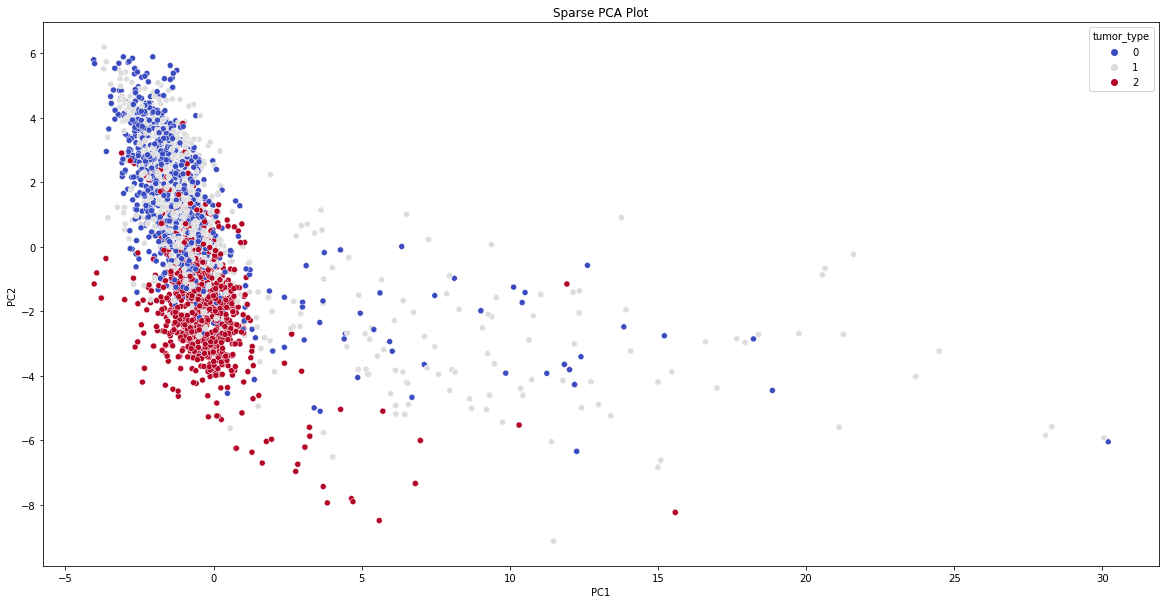

In [167]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Sparse PCA Plot')
plt.show()

In [168]:
## According toa  paper by Camacho et al. (2019) , 

In [169]:
P = spca.components_.T  # loadings
T = spca.transform(X_features)  # score
Xc = X_features - X_features.mean(axis=0)  # center data

explained_variance = np.trace(P @ T.T @ T @ P.T)
total_variance = np.trace(Xc.T @ Xc)
print('Fraction explained variance:', explained_variance / total_variance)

Fraction explained variance: 0.9758329879469207


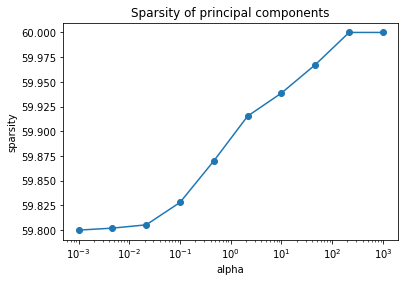

In [182]:
alphas = np.logspace(-3, 3, num=10)

# Compute the sparsity of the principal components for each value of alpha
sparsity = []
for alpha in alphas:
    sparce_pca = SparsePCA(n_components=5, alpha=alpha)
    sparce_pca.fit(X_features)
    sparsity.append(len(component) - np.mean([np.count_nonzero(component) for component in sparce_pca.components_]) / np.prod(sparce_pca.components_.shape))

# Plot the sparsity of the principal components as a function of alpha
plt.semilogx(alphas, sparsity, marker='o')
plt.xlabel('alpha')
plt.ylabel('sparsity')
plt.title('Sparsity of principal components')
plt.show()

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, df['tumor_type'], test_size=0.3, random_state=42)

In [144]:
# train an LDA classification model
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

# evaluate the model
y_pred = lqa.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: QDA", acc)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = knn.score(X_test, y_test)
print("Accuracy: KNN ", accuracy)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# evaluate the model
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy Random Forests:", acc)

Accuracy: QDA 0.28313253012048195
Accuracy: KNN  0.7614457831325301
Accuracy Random Forests: 0.8120481927710843


In [145]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       292
           1       0.75      0.80      0.78       286
           2       0.87      0.92      0.89       252

    accuracy                           0.81       830
   macro avg       0.81      0.82      0.81       830
weighted avg       0.81      0.81      0.81       830



In [88]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 14],
    'min_samples_leaf': [1, 2, 4, 6]
}
rfc = RandomForestClassifier(random_state=40)

grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding mean test score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean test score: ", grid_search.best_score_)

Best hyperparameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best mean test score:  0.8014660400851508


In [89]:
get_cv_error(rf,X_pca, df['tumor_type'])

The Cross Validated Mean Error Score for RandomForestClassifier(random_state=42) : 0.8281521083942659


In [90]:
tree = DecisionTreeClassifier(max_depth=1, random_state=42)

# Create AdaBoost object with decision tree as base estimator
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=100, random_state=42)

# Fit AdaBoost on training data
ada.fit(X_train, y_train)

y_pred_ada = ada.predict(X_test)
ada_accuracy = accuracy_score(y_test, y_pred_ada)
print("AdaBoost accuracy:", ada_accuracy)

AdaBoost accuracy: 0.6807228915662651


### Kernel PCA

In [92]:
from sklearn.decomposition import KernelPCA

In [93]:
### Show all the different kernel graphs and compare the ML predictions

In [146]:
kernels = ['poly', 'rbf', 'linear', 'sigmoid']

In [147]:
k_models = []

In [148]:
X_pca_list = []

In [149]:
for k in kernels:
    k_pca = KernelPCA(kernel = k, n_components = 6)
    k_models.append(k_pca)
    X_k_pca = k_pca.fit_transform(X_features)
    X_pca_list.append(X_k_pca)

/Users/vishnuramjatin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/vishnuramjatin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/vishnuramjatin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

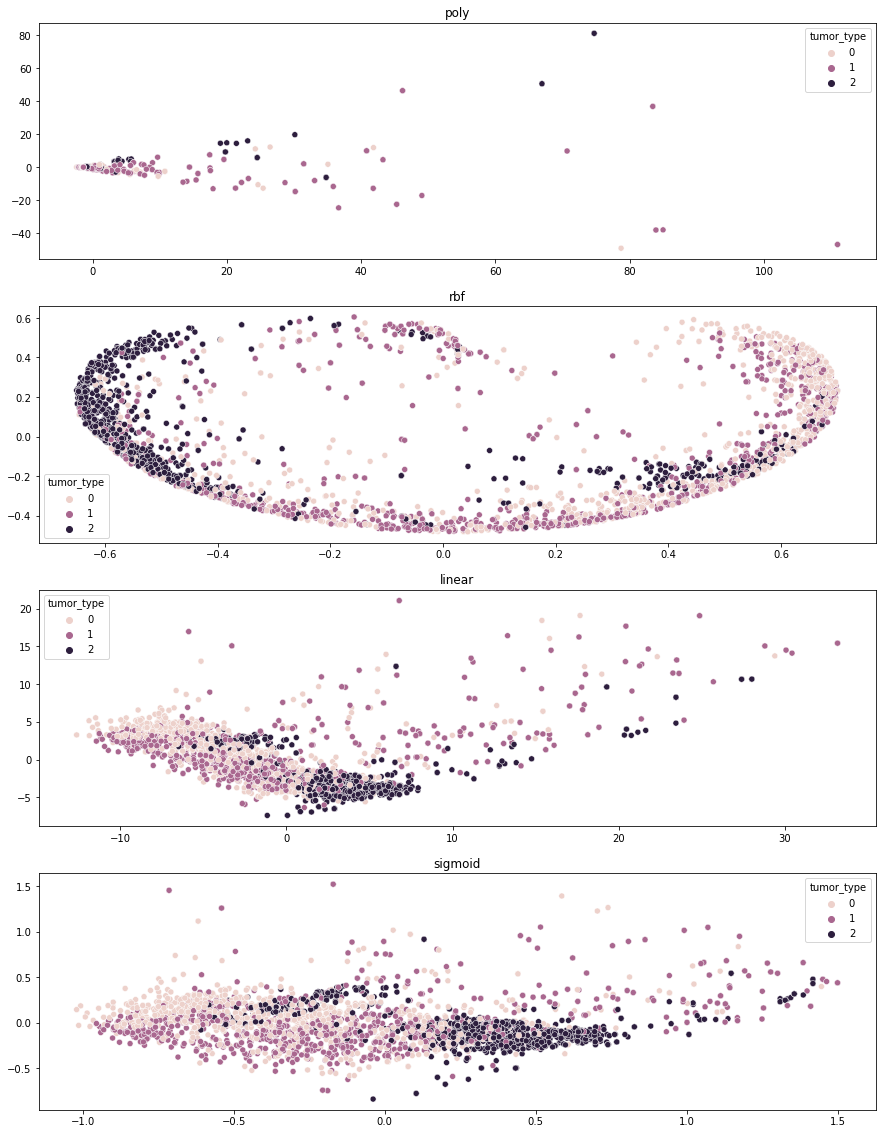

In [150]:
fig, axs = plt.subplots(4,1, figsize=(15, 20))
for i in range(4):        
    sns.scatterplot(X_pca_list[i][:, 0], X_pca_list[i][:, 1], hue=df['tumor_type'], ax=axs[i])
    axs[i].set_title(kernels[i])

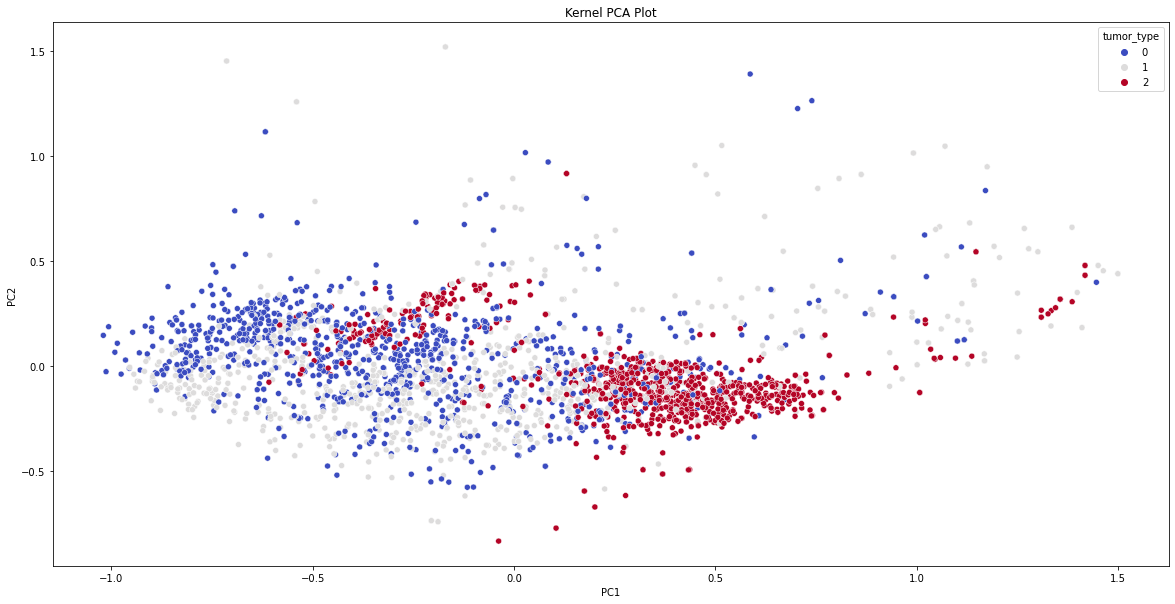

In [151]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=X_k_pca[:, 0], y=X_k_pca[:, 1], hue=df['tumor_type'], palette='coolwarm')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Kernel PCA Plot')
plt.show()

In [152]:
from mpl_toolkits import mplot3d

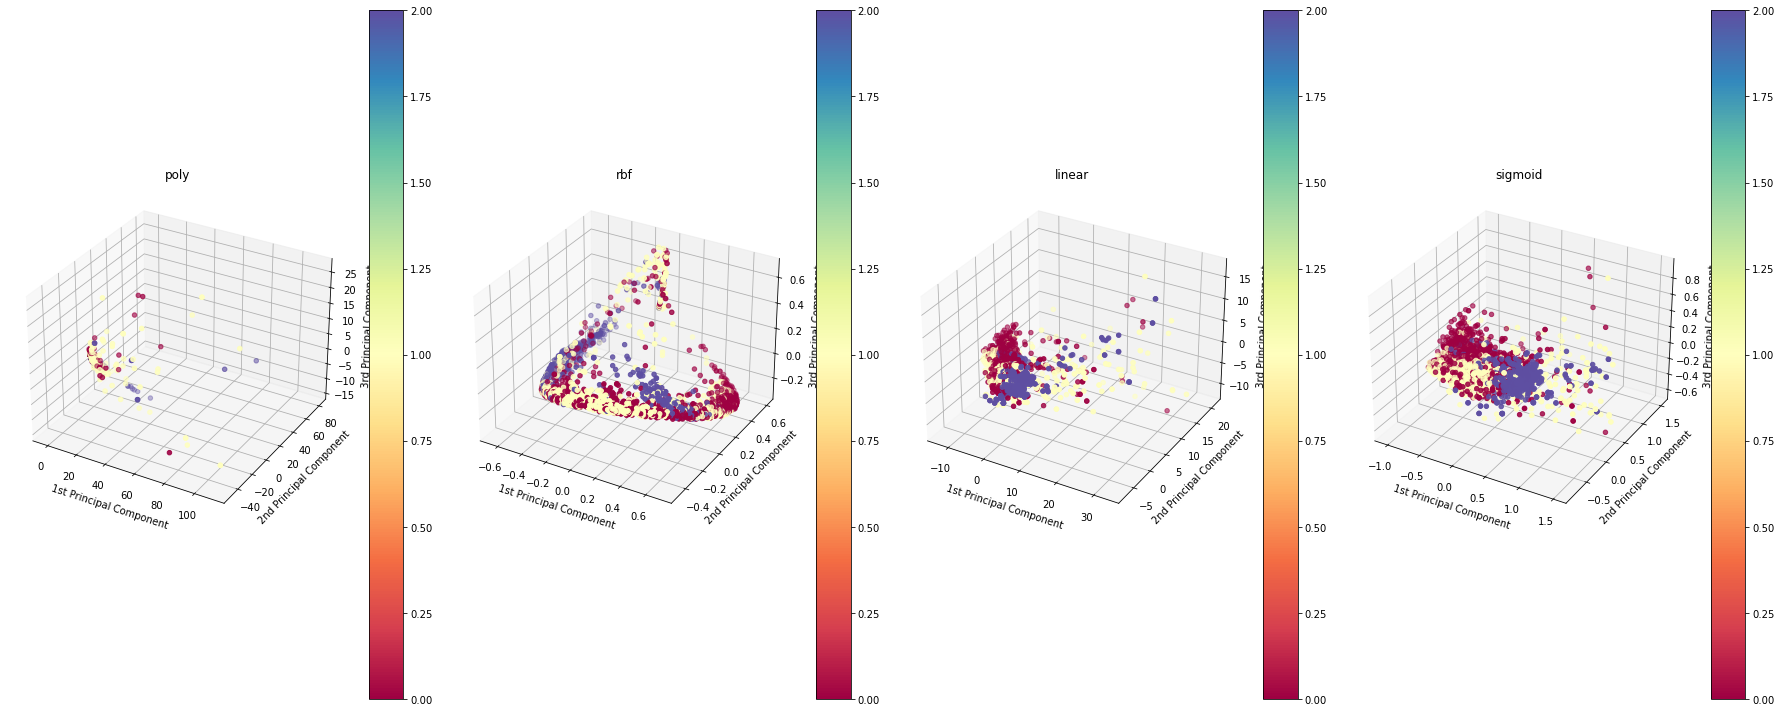

In [153]:
fig = plt.figure(figsize=(25,10))
axs = fig.subplots(nrows=1, ncols=4, subplot_kw={'projection': '3d'})
for i in range(4):
    # Get the index of the current kernel
    k_idx = i
    ax = axs[i]
    scatter = ax.scatter(X_pca_list[i][:, 0], X_pca_list[i][:, 1], X_pca_list[i][:, 2], c=df['tumor_type'], cmap=plt.cm.Spectral)
    ax.set_title(kernels[i])
    ax.set_xlabel('1st Principal Component')
    ax.set_ylabel('2nd Principal Component')
    ax.set_zlabel('3rd Principal Component')
    fig.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.show()

In [154]:
for i in range(4):
    X_train, X_test, y_train, y_test = train_test_split(X_pca_list[i], df['tumor_type'], test_size=0.3, random_state=42)

    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # evaluate the model
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy for Kernel {kernels[i]}:", acc) 
    print(classification_report(y_test, y_pred))

Accuracy for Kernel poly: 0.7060240963855422
              precision    recall  f1-score   support

           0       0.68      0.62      0.65       292
           1       0.68      0.65      0.66       286
           2       0.75      0.87      0.81       252

    accuracy                           0.71       830
   macro avg       0.70      0.71      0.71       830
weighted avg       0.70      0.71      0.70       830

Accuracy for Kernel rbf: 0.7240963855421687
              precision    recall  f1-score   support

           0       0.70      0.65      0.67       292
           1       0.69      0.65      0.67       286
           2       0.77      0.89      0.83       252

    accuracy                           0.72       830
   macro avg       0.72      0.73      0.73       830
weighted avg       0.72      0.72      0.72       830

Accuracy for Kernel linear: 0.8180722891566266
              precision    recall  f1-score   support

           0       0.84      0.76      0.80    

In [111]:
for i in range(4):
    print(f"Kernel {kernels[i]}")
    get_cv_error(rf, X_pca_list[i], df['tumor_type'])

Kernel poly
The Cross Validated Mean Error Score for RandomForestClassifier(random_state=42) : 0.72721060355898
Kernel rbf
The Cross Validated Mean Error Score for RandomForestClassifier(random_state=42) : 0.7456593809785884
Kernel linear
The Cross Validated Mean Error Score for RandomForestClassifier(random_state=42) : 0.8143990617711037
Kernel sigmoid
The Cross Validated Mean Error Score for RandomForestClassifier(random_state=42) : 0.7641075032104202


In [112]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Create decision tree object
tree = DecisionTreeClassifier(max_depth=1, random_state=42)

# Create AdaBoost object with decision tree as base estimator
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=100, random_state=42)

# Fit AdaBoost on training data
ada.fit(X_train, y_train)

y_pred_ada = ada.predict(X_test)
ada_accuracy = accuracy_score(y_test, y_pred_ada)
print("AdaBoost accuracy:", ada_accuracy)

AdaBoost accuracy: 0.6325301204819277


In [14]:
a = [{'created_at': '2020-04-18T18:52:04.000Z', 'id_str': '1251584297972019202', 'text': 'Elon Musk Jeff Bezos and all who have set aside billions of dollars to colonise the Mars, should immediately divert… https://t.co/1S79oPtUxK', 'retweet_count': 136, 'user_id_str': '104083947', 'user_name': 'Nirmal Jain', 'hashtags': [], 'score': 16.9241104126}, {'created_at': '2020-04-25T13:00:16.000Z', 'id_str': '1254032480610508807', 'text': 'Looks like Core1 is running that rogue app spitting out Elon’s BS Corona tweets since January 2020. \n\ndig_yourself_… https://t.co/DdsO4McL96', 'retweet_count': 0, 'user_id_str': '54856859', 'user_name': 'TalesFromTheFuture', 'hashtags': [], 'score': 8.3902111053}, {'created_at': '2020-04-25T13:30:48.000Z', 'id_str': '1254040165120606209', 'text': 'Bu ne yaağğğ doluşmuşsunuz yine dışarı maskeli maskeli ninja kaplumbağalar gibi aloo corona var coronoa M.Ö', 'retweet_count': 0, 'user_id_str': '806521680596205568', 'user_name': 'Fatma Çamur', 'hashtags': [], 'score': 3.8309662342}, {'created_at': '2020-04-24T10:23:44.000Z', 'id_str': '1253630699124527104', 'text': 'We’re staying at home, but we won’t stay quiet! Because it’s our future that’s at stake and masks alone won’t save… https://t.co/TJdw1TybTR', 'retweet_count': 18, 'user_id_str': '1189043576', 'user_name': 'People vs. Oil', 'hashtags': [], 'score': 3.8011159897}, {'created_at': '2020-04-25T13:25:10.000Z', 'id_str': '1254038746649047043', 'text': '@PokemonGOdeu Zum schnorcheln an irgendein Riff - Fische haben kein Corona und Maske muss ich eh tragen', 'retweet_count': 0, 'user_id_str': '3727511476', 'user_name': 'Paincat', 'hashtags': [], 'score': 3.4244365692}, {'created_at': '2020-04-25T10:06:47.000Z', 'id_str': '1253988819285815297', 'text': 'Chale d soundtrack alone 💔', 'retweet_count': 1, 'user_id_str': '999466474216542213', 'user_name': 'Kow Otis 🇬🇭', 'hashtags': [], 'score': 3.1988832951}, {'created_at': '2020-04-25T13:46:18.000Z', 'id_str': '1254044064019693568', 'text': '“Acting Alone At Home With Friends Who Are Also Acting Alone At Home.” Part 40:The improvised @GaryAWilliams… https://t.co/sEtGGw5E4s', 'retweet_count': 0, 'user_id_str': '71199966', 'user_name': 'Gary A Williams', 'hashtags': [], 'score': 3.1748652458}, {'created_at': '2020-04-25T13:02:11.000Z', 'id_str': '1254032961978187777', 'text': 'you must be joking.They told us all along not to go to hospitals because of lack of hygiene, poor sanitation of the… https://t.co/DQoJlokNQg', 'retweet_count': 0, 'user_id_str': '564711194', 'user_name': 'anna rosa', 'hashtags': [], 'score': 3.1387057304}, {'created_at': '2020-04-25T12:22:43.000Z', 'id_str': '1254023029983776769', 'text': "@Katy_Scarletta @Belfast12040260 @BelTel I did.  Must be busy curing the Corona virus.  Didn't answer.", 'retweet_count': 0, 'user_id_str': '1005168498', 'user_name': 'Philip', 'hashtags': [], 'score': 3.0908956528}, {'created_at': '2020-04-25T12:49:27.000Z', 'id_str': '1254029758502965252', 'text': 'Covid 19-South Korea-2 Year distancing to keep Corona under control.South Africa must make the wearing of masks com… https://t.co/m1l6KGJs6v', 'retweet_count': 0, 'user_id_str': '2739234251', 'user_name': 'Irene B', 'hashtags': [], 'score': 3.0361127853}]

In [15]:
type(a)

list

In [17]:
a.append({'elapsed_time':5432})